# CIFAR-10 Classification Experiments

## Dataset
- Using CIFAR-10 dataset
- Images normalized to [0,1] range
- Training data split into training (80%) and validation (20%) sets

## Common Implementation Details
- Batch size: 32
- Maximum epochs: 100
- Early stopping with patience of 15 epochs
- L2 regularization values tested: [1e-3, 1e-4, 1e-5, 1e-6]
- Data augmentation techniques:
  - Rotation (up to 20 degrees)
  - Width/height shifts (20%)
  - Shear transformation
  - Zoom
  - Horizontal flips

## Experiment Overview
Testing three different CNN model architectures, each progressively more complex than the previous one. For each model, we:
1. Test different L2 regularization values
2. Monitor validation accuracy
3. Use early stopping to prevent overfitting
4. Apply consistent data augmentation
5. Use learning rate scheduling

## Experimental Goals
1. Find optimal regularization strength for each model
2. Compare performance between different model complexities
3. Evaluate impact of regularization on model stability
4. Assess training time vs. performance tradeoffs

####Importing the neccessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import imgaug as ia
import imgaug.augmenters as iaa

The following code sets random seeds for reproducibility:

- `np.random.seed(42)`: Sets the seed for NumPy's random number generator to ensure consistent results across runs.
- `tf.random.set_seed(42)`: Sets the seed for TensorFlow's random number generator to ensure consistent initialization of variables and operations.

By fixing the seed, the results of experiments can be reproduced even after restarting or re-running the code.


In [ ]:
# Seed for NumPy
np.random.seed(42)

# Seed for TensorFlow
tf.random.set_seed(42)

####Loading the cifar10 dataset from Keras

In [ ]:
# Loading the data
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

# Normalizing the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('Features -------------> Normalized.')

# Flattening the labels
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

print('Labels -------------> Reshaped.')

# Splitting training data into training and validation sets
val_split = 0.2
val_samples = int(len(X_train) * val_split)



# Shuffling the training data
indices = np.random.permutation(len(X_train))
X_train_shuffled = X_train[indices]
Y_train_shuffled = Y_train[indices]

# Splitting into training and validation
X_val = X_train_shuffled[:val_samples]
Y_val = Y_train_shuffled[:val_samples]
X_train = X_train_shuffled[val_samples:]
Y_train = Y_train_shuffled[val_samples:]
print('Data Split into training and validation -------------> Done')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Features -------------> Normalized.
Labels -------------> Reshaped.
Data Split into training and validation -------------> Done


In [ ]:
X_train.shape

(40000, 32, 32, 3)

In [ ]:
X_val.shape

(10000, 32, 32, 3)

Defining names of the 10 classes in cifar-10

In [ ]:
classes = ["airplane" , "automobile" , "bird" , "cat" , "deer", "dog" , "frog", " horse" , "ship" , "truck"]

In [ ]:
classes[9]

'truck'

In [ ]:
Y_train[:5]

array([3, 8, 6, 1, 3], dtype=uint8)

## Training parameters

In [ ]:
BATCH_SIZE = 32
N_EPOCH = 100
N_CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM =  Adam() # RMSprop()
INPUT_SHAPE = (32, 32, 3)
l2_values=[1e-3, 1e-4, 1e-5, 1e-6]

print('Initialised -------------> Main parameters.')

Initialised -------------> Main parameters.


## Defining a function for early stopping

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience= 15,
    restore_best_weights=True
)

## Data Augmentation

Data augmentation is employed to artificially increase the size of the training dataset and improve the model's generalization ability. The following techniques are used:

* `rotation_range=15`: Randomly rotate images by up to 15 degrees.
* `width_shift_range=0.1`: Randomly shift images horizontally by up to 10% of the width.
* `height_shift_range=0.1`: Randomly shift images vertically by up to 10% of the height.
* `horizontal_flip=True`: Randomly flip images horizontally.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


Instead of using data augmentation the fly, we are using static data augmentation for **speeding up the training process**. In this case, the following augmentations are used:

* **`iaa.Fliplr(0.5)`:** Randomly flips images horizontally with a 50% probability. This helps the model learn features that are invariant to left-right orientation.
* **`iaa.Crop(percent=(0, 0.1))`:**  Randomly crops images by up to 10%. This forces the model to learn features from different parts of the image and reduces the reliance on specific regions.
* **`iaa.Affine(rotate=(-15, 15))`:** Randomly rotates images between -15 and 15 degrees. This helps the model become invariant to slight rotations in the input data.
* **`iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})`:** Randomly translates images horizontally and vertically by up to 10% of the image width and height, respectively. This helps the model learn features that are robust to changes in object position.

These augmentations are applied sequentially to the training, test, and validation sets (`X_train`, `X_test`, `X_val`) using the `iaa.Sequential` object. This ensures that the model is trained and evaluated on a diverse set of images, leading to improved performance and generalization.

In [ ]:
seq = iaa.Sequential([
    # Horizontal flips
    iaa.Fliplr(0.5),
    # Random crops
    iaa.Crop(percent=(0, 0.1)),
    # Rotations
    iaa.Affine(rotate=(-15, 15)),
    # Translations
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
])

# Applying the augmentations
X_train_aug = seq(images=X_train)
X_test_aug = seq(images=X_test)
X_val_aug = seq(images=X_val)

# Running experiments to figure out the best values for hyper-parameters for Model-1

# CNN Model 1: Archtecture

This document outlines the architecture and implementation details of our enhanced baseline Convolutional Neural Network (CNN) model for image classification. This model builds upon the initial baseline model by incorporating additional convolutional layers and batch normalization for improved performance.

## Model Architecture

The model consists of the following layers:

* **Convolutional Layers:**
    * Three convolutional blocks with increasing filter counts (32, 64, 128). Each block includes:
        * Two `Conv2D` layers with `relu` activation function.
        * `kernel_size` of (3, 3) for all convolutional layers.
        * `padding='same'` to preserve spatial dimensions.
        * `BatchNormalization` to normalize activations and speed up training.
        * `l2` kernel regularization applied to the convolutional layers to prevent overfitting.
    * `MaxPooling2D` layers with a pool size of (2, 2) for downsampling.
    * `Dropout` layers with a rate of 0.25 to prevent overfitting.

* **Global Average Pooling:**
    * `GlobalAveragePooling2D` layer to reduce dimensionality and improve generalization.

* **Dense Layers:**
    * `Flatten` layer to convert feature maps to a 1D vector.
    * `Dense` layer with 512 neurons and `relu` activation.
    * `BatchNormalization` to normalize activations.
    * `Dropout` layer with a rate of 0.5 to prevent overfitting.
    * Output `Dense` layer with `N_CLASSES` neurons and `softmax` activation for probability distribution over classes.


## Model Compilation and Training

* **Optimizer:** `Adam` optimizer with a learning rate of 0.0001.
* **Loss Function:** `sparse_categorical_crossentropy`.
* **Metrics:** `accuracy`.
* **Data Augmentation:** The model is trained using augmented data from `ImageDataGenerator` with on-the-fly augmentations. This helps increase the diversity of the training data and improve the model's generalization ability.
* **Training Process:** The model is trained in two phases:
    * **Phase 1:**  Trained with data augmentation on the flow.
    * **Phase 2:** Trained with static data augmentation to potentially increase the training speed.

### Function to create models with given parameters

In [ ]:
def create_model_with_l2(input_shape, num_classes, l2_value):

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.35),

        # Third Convolutional Block
        layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Fullly connected layers for classification
        layers.Flatten(),
        layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Function to train the model with different hyper-parameter values

In [ ]:
def train_model_with_l2(model, X_train, Y_train, X_val, Y_val, epochs=50, batch_size=32):

    # Learning rate schedule for the optimizer
    def lr_schedule(epoch):
        initial_lr = 0.001
        drop = 0.5
        epochs_drop = 10.0
        lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        return lr

    # Training the model
    history = model.fit(X_train, Y_train, batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping,tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
                        verbose=1
    )

    return model, history

### Function for Results Visualization

In [ ]:
def plot_l2_results(results):

    plt.figure(figsize=(12, 5))

    # Comparing the Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.title('Validation Accuracy for Different L2 Values')
    plt.bar(
        [str(l2) for l2 in results.keys()],
        [results[l2]['val_accuracy'] for l2 in results.keys()]
    )
    plt.ylabel('Validation Accuracy')
    plt.xlabel('L2 Regularization Value')
    plt.xticks(rotation=45)

    # Finding the best L2 value
    best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
    best_result = results[best_l2]

    # Training History for Best Model
    plt.subplot(1, 2, 2)
    plt.title(f'Training History (Best L2: {best_l2})')
    plt.plot(best_result['history'].history['accuracy'], label='Training Accuracy')
    plt.plot(best_result['history'].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best L2 Value: {best_l2}")
    print(f"Best Validation Accuracy: {best_result['val_accuracy']:.4f}")

### Function for storing the results of each model  

In [ ]:
def tune_l2_regularization(X_train, Y_train, X_val, Y_val, input_shape, num_classes, l2_values):
    """
    Tune L2 regularization hyperparameter

    Parameters:
    - X_train, Y_train: Training data and labels
    - X_val, Y_val: Validation data and labels
    - input_shape: Shape of input images
    - num_classes: Number of classification classes
    - l2_values: List of L2 regularization values to try
    Returns:
    - Dictionary of results for different L2 values
    """
    # Dictionary for storing the results
    results = {}

    # Try each L2 value
    for l2_value in l2_values:
        # Clearing the previous model and session to prevent any memory erros
        tf.keras.backend.clear_session()
        print(f'For model with l2 value -----> ',l2_value)
        # Creating the model
        model = create_model_with_l2(input_shape, num_classes, l2_value)

        # Training the model
        trained_model, history = train_model_with_l2(model, X_train, Y_train, X_val, Y_val)

        # Evaluate the model
        val_loss, val_accuracy = trained_model.evaluate(X_val, Y_val, verbose=0)

        # Store the results
        results[l2_value] = {
            'model': trained_model,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'history': history
        }

    # Visualizing the results
    plot_l2_results(results)

    return results

## Running the test

For model with l2 value ----->  0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.2834 - loss: 3.4005 - val_accuracy: 0.3953 - val_loss: 2.4714 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4359 - loss: 2.2793 - val_accuracy: 0.4803 - val_loss: 1.9909 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5028 - loss: 1.9351 - val_accuracy: 0.5023 - val_loss: 1.9451 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5371 - loss: 1.8191 - val_accuracy: 0.4926 - val_loss: 1.9570 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5646 - loss: 1.7823 - val_accuracy: 0.5482 - val_loss: 1.8676 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5867 - loss: 1.7252 - val_accuracy: 0.6185 - val_loss: 1.6677 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.609

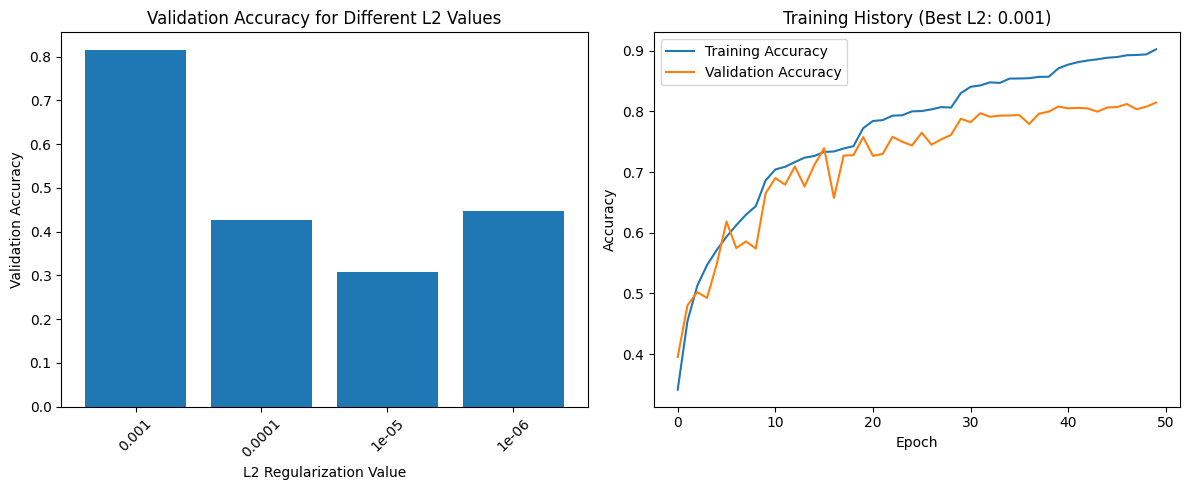

Best L2 Value: 0.001
Best Validation Accuracy: 0.8147
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7195 - loss: 1.3310
Best L2 Value: 0.001
Test Accuracy: 0.7177000045776367
CPU times: user 15min 9s, sys: 37 s, total: 15min 46s
Wall time: 17min 17s


In [ ]:
%%time

# Runing the L2 regularization tuning
results = tune_l2_regularization(
    X_train_aug, Y_train,
    X_val_aug, Y_val,
    input_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    l2_values=l2_values
)

# Finding the L2 value with the highest validation accuracy
best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
best_model = results[best_l2]['model']

# Using the best model for evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)
print(f"Best L2 Value: {best_l2}")
print(f"Test Accuracy: {test_accuracy}")

# Running experiments to figure out the best values for hyper-parameters for Model-2

# CNN Model 2: Enhanced Model with Batch Normalization and Deeper Architecture

This document outlines the architecture and implementation details of an enhanced CNN model (`CNN_model_2`) for image classification, building upon previous iterations.

## Key Improvements

* **Batch Normalization:** `BatchNormalization` layers are introduced after each convolutional layer to stabilize training, speed up convergence, and potentially improve overall performance.
* **Deeper Architecture:** A fourth convolutional block has been added to further increase the network's capacity to learn complex features.


## Model Architecture

The model consists of the following layers:

* **Convolutional Layers:**
    * Four convolutional blocks, each with:
        * Two `Conv2D` layers with increasing filter counts (32, 64, 128, 256) except for the fourth layer.
        * `kernel_size` of (3, 3) for all convolutional layers.
        * `padding='same'` to maintain spatial dimensions.
        * `BatchNormalization` after each `Conv2D` layer.
        * `relu` activation function for introducing non-linearity.
    * `MaxPooling2D` layers with a pool size of (2, 2) for downsampling.
    * `Dropout` layers with a rate of 0.25 to prevent overfitting.

* **Dense Layers:**
    * `Flatten` layer to convert feature maps into a 1D vector.
    * `Dense` layer with 512 neurons and `relu` activation.
    * `Dense` layer with 256 neurons and `relu` activation.
    * `Dropout` layer with a rate of 0.25.
    * Output `Dense` layer with `N_CLASSES` neurons and `softmax` activation for probability distribution over classes.

## Model Compilation and Training

* **Optimizer:** `adam` optimizer.
* **Loss Function:** `sparse_categorical_crossentropy`.
* **Metrics:** `accuracy`.
* **Training:** The model is trained using augmented data from `ImageDataGenerator`.



### Function to create models with given parameters

In [ ]:
def create_model_with_l2_arch_2(input_shape, num_classes, l2_value):

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.35),

        # Third Convolutional Block
        layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

         # Fourth Convolutional Block
        layers.Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully connected layers for classification
        layers.Flatten(),
        layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Dropout(0.35),
        layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(l2_value)),
        layers.BatchNormalization(),
        layers.Dropout(0.35),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Function to train the model with different hyper-parameter values

In [ ]:
def train_model_with_l2_arch_2(model, X_train, Y_train, X_val, Y_val, epochs=50, batch_size=32):

    # Learning rate schedule for the optimizer
    def lr_schedule(epoch):
        initial_lr = 0.001
        drop = 0.5
        epochs_drop = 10.0
        lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        return lr

    # Training the model
    history = model.fit(X_train, Y_train, batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping,tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
                        verbose=1
    )

    return model, history

### Function for Results Visualization

In [ ]:
def plot_l2_results_arch_2(results):

    plt.figure(figsize=(12, 5))

    # Comparing the Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.title('Validation Accuracy for Different L2 Values')
    plt.bar(
        [str(l2) for l2 in results.keys()],
        [results[l2]['val_accuracy'] for l2 in results.keys()]
    )
    plt.ylabel('Validation Accuracy')
    plt.xlabel('L2 Regularization Value')
    plt.xticks(rotation=45)

    # Finding best L2 value
    best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
    best_result = results[best_l2]

    # Training History for Best Model
    plt.subplot(1, 2, 2)
    plt.title(f'Training History (Best L2: {best_l2})')
    plt.plot(best_result['history'].history['accuracy'], label='Training Accuracy')
    plt.plot(best_result['history'].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Printing the best result details
    print(f"Best L2 Value: {best_l2}")
    print(f"Best Validation Accuracy: {best_result['val_accuracy']:.4f}")

### Main L2 Regularization Tuning Function

In [ ]:
def tune_l2_regularization_arch_2(X_train, Y_train, X_val, Y_val, input_shape, num_classes, l2_values):
    """
    Tune L2 regularization hyperparameter

    Parameters:
    - X_train, Y_train: Training data and labels
    - X_val, Y_val: Validation data and labels
    - input_shape: Shape of input images
    - num_classes: Number of classification classes
    - l2_values: List of L2 regularization values to try

    Returns:
    - Dictionary of results for different L2 values
    """
    # Dictionary to store results
    results = {}

    # Try each L2 value
    for l2_value in l2_values:
        # Clearing the previous model and session to prevent any memory erros
        tf.keras.backend.clear_session()
        print(f'For model with l2 value -----> ',l2_value)
        # Creating the  model
        model = create_model_with_l2_arch_2(input_shape, num_classes, l2_value)

        # Training the model
        trained_model, history = train_model_with_l2_arch_2(model, X_train, Y_train, X_val, Y_val)

        # Evaluating the  model
        val_loss, val_accuracy = trained_model.evaluate(X_val, Y_val, verbose=0)

        # Storing the results
        results[l2_value] = {
            'model': trained_model,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'history': history
        }

    # Visualizing the results
    plot_l2_results(results)

    return results

## Running the test

For model with l2 value ----->  0.001
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.2610 - loss: 4.1972 - val_accuracy: 0.3411 - val_loss: 2.9188 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4336 - loss: 2.3273 - val_accuracy: 0.3390 - val_loss: 2.6688 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5051 - loss: 1.8829 - val_accuracy: 0.5063 - val_loss: 1.8826 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5471 - loss: 1.7769 - val_accuracy: 0.5215 - val_loss: 1.8926 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5833 - loss: 1.7417 - val_accuracy: 0.4932 - val_loss: 2.0126 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6087 - loss: 1.7209 - val_accuracy: 0.5284 - val_loss: 2.0531 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━

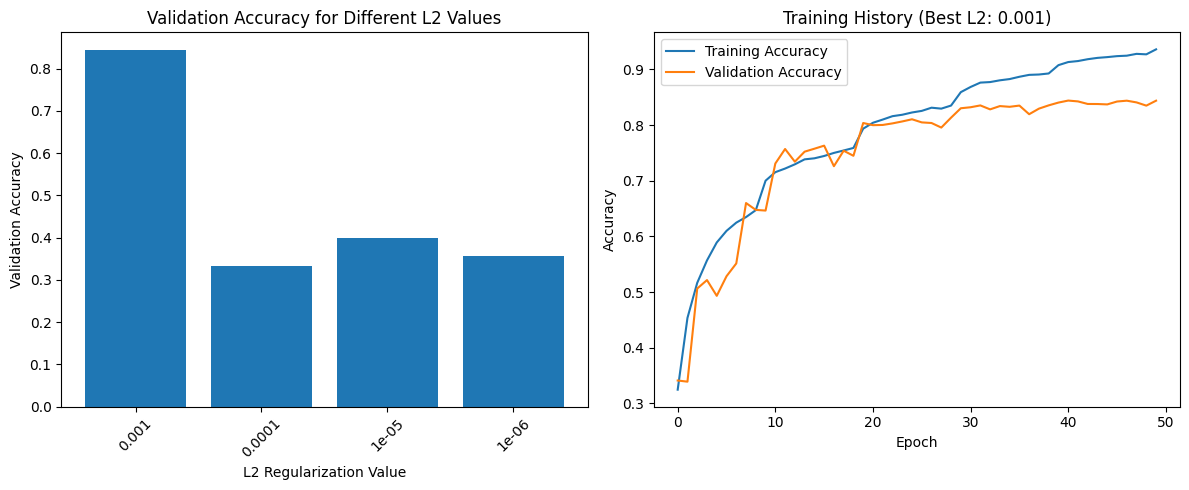

Best L2 Value: 0.001
Best Validation Accuracy: 0.8440
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7508 - loss: 1.2955
Best L2 Value: 0.001
Test Accuracy: 0.7461000084877014
CPU times: user 22min 48s, sys: 45.9 s, total: 23min 34s
Wall time: 29min 11s


In [ ]:
%%time

# Running the L2 regularization tuning
results = tune_l2_regularization_arch_2(
    X_train_aug, Y_train,
    X_val_aug, Y_val,
    input_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    l2_values=l2_values
)

# Finding the L2 value with the highest validation accuracy
best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
best_model = results[best_l2]['model']

# Using the best model for evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)
print(f"Best L2 Value: {best_l2}")
print(f"Test Accuracy: {test_accuracy}")

# Running experiments to figure out the best values for hyper-parameters for Model-3

# Model 3 Architecture

#### Function for creating data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)


### Function to create models with given parameters

In [ ]:
def create_model_with_l2_arch_3(input_shape, num_classes, l2_value):

    # Input layer
    inputs = layers.Input(shape=INPUT_SHAPE)

    # Initial convolution
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # First Residual Block
    residual = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)

    # Merging the first residual connection with the convolution layer
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second Residual Block
    residual = layers.Conv2D(filters=128, kernel_size=(1, 1), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)

    x = layers.Conv2D(filters=128,kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)

    # Merging the second residual connection with the convolution layer
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    # Third Residual Block
    residual = layers.Conv2D(filters=256,kernel_size= (1, 1), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)

    x = layers.Conv2D(filters=256,kernel_size= (3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=256,kernel_size= (3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)

    # Merging the third residual connection with the convolution layer
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Fully Connected Layers for classification
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(N_CLASSES, activation='softmax')(x)

    # Creating model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compiling model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Function to train the model with different hyper-parameter values

In [ ]:
def train_model_with_l2_arch_3(model, train_generator, X_val, Y_val, epochs=50, batch_size=32):

    # Learning rate schedule for the optimizer
    def lr_schedule(epoch):
        initial_lr = 0.001
        drop = 0.5
        epochs_drop = 10.0
        lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        return lr

    # Training the model
    history = model.fit(train_generator, batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping,tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
                        verbose=1
    )

    return model, history

### Function for Results Visualization

In [ ]:
def plot_l2_results_arch_3(results):

    plt.figure(figsize=(12, 5))

    # Comparing the Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.title('Validation Accuracy for Different L2 Values')
    plt.bar(
        [str(l2) for l2 in results.keys()],
        [results[l2]['val_accuracy'] for l2 in results.keys()]
    )
    plt.ylabel('Validation Accuracy')
    plt.xlabel('L2 Regularization Value')
    plt.xticks(rotation=45)

    # Finding best L2 value
    best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
    best_result = results[best_l2]

    # Training History for Best Model
    plt.subplot(1, 2, 2)
    plt.title(f'Training History (Best L2: {best_l2})')
    plt.plot(best_result['history'].history['accuracy'], label='Training Accuracy')
    plt.plot(best_result['history'].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Printing the best result details
    print(f"Best L2 Value: {best_l2}")
    print(f"Best Validation Accuracy: {best_result['val_accuracy']:.4f}")

### Main L2 Regularization Tuning Function

In [ ]:
def tune_l2_regularization_arch_3(train_generator, X_val, Y_val, input_shape, num_classes, l2_values):
    """
    Tune L2 regularization hyperparameter

    Parameters:
    - X_train, Y_train: Training data and labels
    - X_val, Y_val: Validation data and labels
    - input_shape: Shape of input images
    - num_classes: Number of classification classes
    - l2_values: List of L2 regularization values to try

    Returns:
    - Dictionary of results for different L2 values
    """
    # Dictionary to store results
    results = {}

    # Try each L2 value
    for l2_value in l2_values:
        # Clearing the previous model and session to prevent any memory erros
        tf.keras.backend.clear_session()
        print(f'For model with l2 value -----> ',l2_value)
        # Creating the  model
        model = create_model_with_l2_arch_3(input_shape, num_classes, l2_value)

        # Training the model
        trained_model, history = train_model_with_l2_arch_3(model, train_generator, X_val, Y_val)

        # Evaluating the  model
        val_loss, val_accuracy = trained_model.evaluate(X_val, Y_val, verbose=0)

        # Storing the results
        results[l2_value] = {
            'model': trained_model,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'history': history
        }

    # Visualizing the results
    plot_l2_results_arch_3(results)

    return results

## Running the test

For model with l2 value ----->  0.001
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - accuracy: 0.2441 - loss: 5.3933 - val_accuracy: 0.3930 - val_loss: 3.1120 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 29ms/step - accuracy: 0.4202 - loss: 2.8610 - val_accuracy: 0.3792 - val_loss: 2.7422 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.4732 - loss: 2.2343 - val_accuracy: 0.4810 - val_loss: 2.3719 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.5099 - loss: 2.0956 - val_accuracy: 0.4450 - val_loss: 2.5868 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.5353 - loss: 2.0642 - val_accuracy: 0.4872 - val_loss: 2.3412 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.5527 - loss: 1.9840 - val_accuracy: 0.4573 - val_loss: 2.4197 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5561 

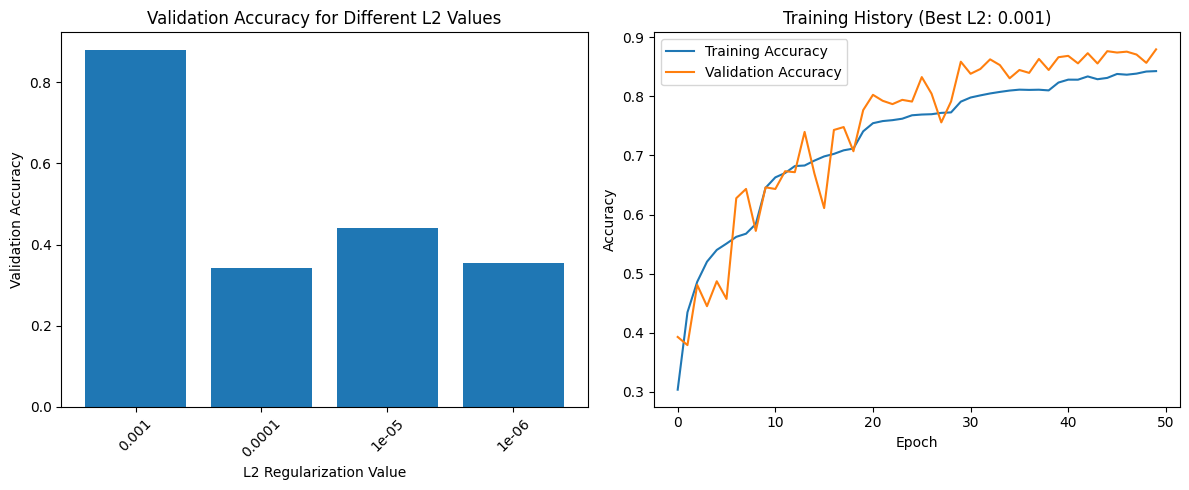

Best L2 Value: 0.001
Best Validation Accuracy: 0.8793
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8773 - loss: 0.5766
Best L2 Value: 0.001
Test Accuracy: 0.876800000667572
CPU times: user 1h 16min 15s, sys: 1min 21s, total: 1h 17min 37s
Wall time: 1h 4min 18s


In [ ]:
%%time

# Running the L2 regularization tuning
results = tune_l2_regularization_arch_3(
   train_generator,
    X_val, Y_val,
    input_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    l2_values=l2_values
)

# Finding the L2 value with the highest validation accuracy
best_l2 = max(results, key=lambda k: results[k]['val_accuracy'])
best_model = results[best_l2]['model']

# Using the best model for evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)
print(f"Best L2 Value: {best_l2}")
print(f"Test Accuracy: {test_accuracy}")